In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from typing import Tuple


In [26]:
def find_dataset_files() -> Tuple[str, str]:
    cwd = os.getcwd()
    common_pairs = [
        ('/mnt/data/train.csv', '/mnt/data/test.csv'),
        ('./train.csv', './test.csv'),
        ('./data/train.csv', './data/test.csv')
    ]
    for tpath, tepath in common_pairs:
        if os.path.exists(tpath) and os.path.exists(tepath):
            return os.path.abspath(tpath), os.path.abspath(tepath)
    found_train = None
    found_test = None
    for root, dirs, files in os.walk(cwd):
        for f in files:
            if f.lower() == 'train.csv' and found_train is None:
                found_train = os.path.join(root, f)
            if f.lower() == 'test.csv' and found_test is None:
                found_test = os.path.join(root, f)
        if found_train and found_test:
            break
    if found_train and found_test:
        return os.path.abspath(found_train), os.path.abspath(found_test)
    return None, None

def maybe_create_sample_data(train_path: str = './train.csv', test_path: str = './test.csv') -> Tuple[str, str]:
    rng = np.random.RandomState(42)
    m_train = 200
    m_test = 50
    columns = [
        'high', 'low', 'momentum_index', 'beta_indicator', 'risk_premium', 'index',
        'volatility_factor', 'technical_score', 'oscillator_value', 'liquidity_ratio',
        'open', 'quant_index', 'trend_strength'
    ]
    def make_df(m):
        data = {}
        for i, col in enumerate(columns):
            scale = (i % 5 + 1) * 10
            data[col] = rng.randn(m) * scale + (i * 5)
        weights = rng.randn(len(columns)) * 2.0
        X = np.column_stack([data[c] for c in columns])
        close = X.dot(weights) + 50 + rng.randn(m) * 5.0
        data['close'] = close
        return pd.DataFrame(data)
    train_df = make_df(m_train)
    test_df = make_df(m_test)
    train_df.to_csv(train_path, index=False)
    test_df.to_csv(test_path, index=False)
    print(f"Created synthetic datasets for quick testing: {os.path.abspath(train_path)}, {os.path.abspath(test_path)}")
    return os.path.abspath(train_path), os.path.abspath(test_path)


In [27]:
def load_data(train_path: str = None, test_path: str = None) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if train_path and test_path:
        if os.path.exists(train_path) and os.path.exists(test_path):
            return pd.read_csv(train_path), pd.read_csv(test_path)
        else:
            print(f"Provided paths not found: {train_path}, {test_path}")
    found_train, found_test = find_dataset_files()
    if found_train and found_test:
        print(f"Found datasets:\n  train: {found_train}\n  test : {found_test}")
        return pd.read_csv(found_train), pd.read_csv(found_test)
    print("Could not find train.csv and test.csv in common locations. Creating small synthetic datasets for testing.")
    new_train, new_test = maybe_create_sample_data()
    return pd.read_csv(new_train), pd.read_csv(new_test)


In [28]:
def preprocess(df: pd.DataFrame, fit_stats: dict = None) -> Tuple[np.ndarray, np.ndarray, dict]:
    df = df.copy()
    for col in ['date', 'symbols']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(inplace=True)
    if 'close' not in df.columns:
        raise ValueError("'close' column not found in dataframe")
    y = df['close'].values.astype(float)
    X = df.drop(columns=['close']).values.astype(float)
    if fit_stats is None:
        mean = X.mean(axis=0)
        std = X.std(axis=0)
        std[std == 0] = 1.0
        fit_stats = {'mean': mean, 'std': std}
    X = (X - fit_stats['mean']) / fit_stats['std']
    m = X.shape[0]
    X = np.hstack([np.ones((m, 1)), X])
    return X, y, fit_stats


In [29]:
class LinearRegressionGD:
    def __init__(self, n_features: int, lr: float = 0.01):
        self.lr = lr
        self.W = np.zeros(n_features)
    def predict(self, X: np.ndarray) -> np.ndarray:
        return X.dot(self.W)
    def compute_cost(self, X: np.ndarray, y: np.ndarray) -> float:
        m = y.shape[0]
        preds = self.predict(X)
        cost = (1/(2*m)) * np.sum((preds - y)**2)
        return cost
    def compute_gradients(self, X: np.ndarray, y: np.ndarray) -> np.ndarray:
        m = y.shape[0]
        preds = self.predict(X)
        grad = (1/m) * (X.T.dot(preds - y))
        return grad
    def fit(self, X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray = None, y_val: np.ndarray = None,
            epochs: int = 1000, print_every: int = 50) -> dict:
        history = {'cost': [], 'val_cost': [], 'train_acc': [], 'val_acc': []}
        for epoch in range(1, epochs+1):
            grad = self.compute_gradients(X_train, y_train)
            self.W -= self.lr * grad
            cost = self.compute_cost(X_train, y_train)
            history['cost'].append(cost)
            if X_val is not None and y_val is not None:
                val_cost = self.compute_cost(X_val, y_val)
                history['val_cost'].append(val_cost)
            y_pred_train = self.predict(X_train)
            train_acc = compute_accuracy_percentage(y_pred_train, y_train, threshold=0.10)
            history['train_acc'].append(train_acc)
            if X_val is not None and y_val is not None:
                y_pred_val = self.predict(X_val)
                val_acc = compute_accuracy_percentage(y_pred_val, y_val, threshold=0.10)
                history['val_acc'].append(val_acc)
            if epoch % print_every == 0 or epoch == 1 or epoch == epochs:
                if X_val is not None and y_val is not None:
                    print(f"Epoch {epoch:4d} | cost={cost:.4f} | val_cost={val_cost:.4f} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")
                else:
                    print(f"Epoch {epoch:4d} | cost={cost:.4f} | train_acc={train_acc:.4f}")
        return history


In [30]:
def compute_accuracy_percentage(y_pred: np.ndarray, y_true: np.ndarray, threshold: float = 0.10) -> float:
    eps = 1e-8
    denom = np.where(np.abs(y_true) < eps, eps, np.abs(y_true))
    rel_error = np.abs(y_pred - y_true) / denom
    acc = np.mean(rel_error < threshold)
    return acc

def train_pipeline(train_path: str = None, test_path: str = None, epochs: int = 1000, lr: float = 0.01, val_split: float = 0.2):
    train_df, test_df = load_data(train_path, test_path)
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    val_size = int(len(train_df) * val_split)
    val_df = train_df.iloc[:val_size]
    new_train_df = train_df.iloc[val_size:]
    X_train, y_train, stats = preprocess(new_train_df, fit_stats=None)
    X_val, y_val, _ = preprocess(val_df, fit_stats=stats)
    X_test, y_test, _ = preprocess(test_df, fit_stats=stats)
    print(f"Shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}")
    model = LinearRegressionGD(n_features=X_train.shape[1], lr=lr)
    history = model.fit(X_train, y_train, X_val, y_val, epochs=epochs, print_every=max(1, epochs//10))
    plt.figure(figsize=(8,5))
    plt.plot(history['cost'], label='train_cost')
    if len(history['val_cost'])>0:
        plt.plot(history['val_cost'], label='val_cost')
    plt.xlabel('Epochs')
    plt.ylabel('Cost (MSE/2)')
    plt.title('Cost vs Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
    train_final_pred = model.predict(X_train)
    val_final_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    train_acc = compute_accuracy_percentage(train_final_pred, y_train, threshold=0.10)
    val_acc = compute_accuracy_percentage(val_final_pred, y_val, threshold=0.10)
    test_acc = compute_accuracy_percentage(test_pred, y_test, threshold=0.10)
    print('\nFINAL ACCURACIES (within 10%)')
    print(f"Train Accuracy: {train_acc*100:.2f}%")
    print(f"Val   Accuracy: {val_acc*100:.2f}%")
    print(f"Test  Accuracy: {test_acc*100:.2f}%")
    out_df = pd.DataFrame({'y_true': y_test, 'y_pred': test_pred})
    out_df.to_csv('predictions.csv', index=False)
    print('\nSaved test predictions to predictions.csv')
    return model, history, stats


In [31]:
def run_quick_test():
    print("Running quick test with synthetic data (5 epochs)...")
    train_path, test_path = maybe_create_sample_data('./debug_train.csv', './debug_test.csv')
    model, history, stats = train_pipeline(train_path=train_path, test_path=test_path, epochs=5, lr=0.05, val_split=0.2)
    print("Quick test finished.")
    return model, history


Shapes -> X_train: (211438, 17), y_train: (211438,)
Epoch    1 | cost=4662.3059 | val_cost=4558.3922 | train_acc=0.0000 | val_acc=0.0000
Epoch   20 | cost=2052.5179 | val_cost=2032.8397 | train_acc=0.0049 | val_acc=0.0047
Epoch   40 | cost=1312.1496 | val_cost=1308.9253 | train_acc=0.0251 | val_acc=0.0250
Epoch   60 | cost=947.8662 | val_cost=948.4993 | train_acc=0.0527 | val_acc=0.0527
Epoch   80 | cost=715.6344 | val_cost=717.3952 | train_acc=0.0807 | val_acc=0.0827
Epoch  100 | cost=558.5979 | val_cost=560.7314 | train_acc=0.1077 | val_acc=0.1071
Epoch  120 | cost=450.5694 | val_cost=452.8371 | train_acc=0.1328 | val_acc=0.1325
Epoch  140 | cost=375.3354 | val_cost=377.6579 | train_acc=0.1548 | val_acc=0.1548
Epoch  160 | cost=322.1813 | val_cost=324.5320 | train_acc=0.1735 | val_acc=0.1751
Epoch  180 | cost=283.9412 | val_cost=286.3121 | train_acc=0.1895 | val_acc=0.1915
Epoch  200 | cost=255.8110 | val_cost=258.2005 | train_acc=0.2032 | val_acc=0.2050


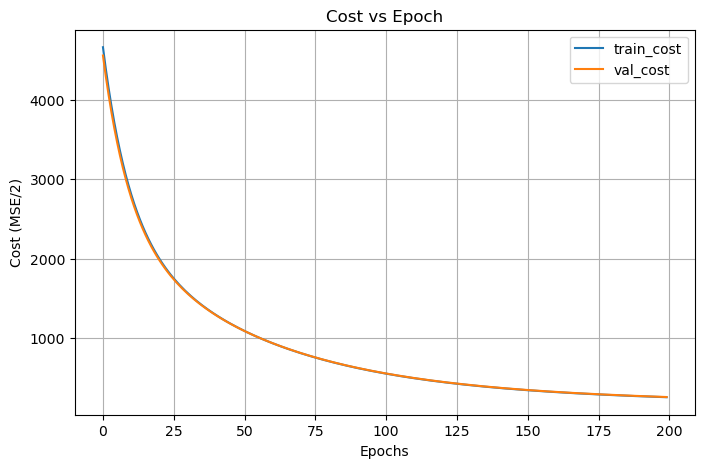


FINAL ACCURACIES (within 10%)
Train Accuracy: 20.32%
Val   Accuracy: 20.50%
Test  Accuracy: 0.01%

Saved test predictions to predictions.csv


In [32]:
model, history, stats = train_pipeline(train_path='./train.csv', test_path='./test.csv', epochs=200, lr=0.01)

